In [2]:
pip install pandas scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


Fitting 3 folds for each of 12 candidates, totalling 36 fits
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 0s 169us/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 162us/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 164us/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 163us/step
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 0s 167us/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 167us/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 164us/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 164us/step
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 166us/step


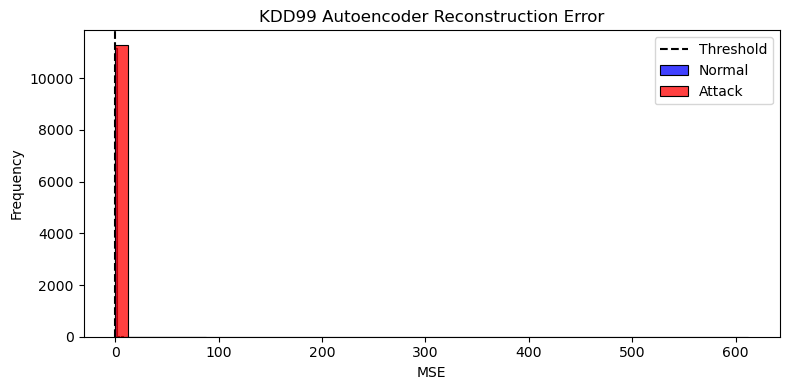


=== Random Forest Report ===
              precision    recall  f1-score       support
0              0.882651  0.992619  0.934410  11245.000000
1              0.991614  0.868661  0.926074  11299.000000
accuracy       0.930491  0.930491  0.930491      0.930491
macro avg      0.937133  0.930640  0.930242  22544.000000
weighted avg   0.937263  0.930491  0.930232  22544.000000
Confusion Matrix:
 [[11162    83]
 [ 1484  9815]]

=== Isolation Forest Report ===
              precision    recall  f1-score       support
0              0.910397  0.896309  0.903298  11245.000000
1              0.898370  0.912205  0.905234  11299.000000
accuracy       0.904276  0.904276  0.904276      0.904276
macro avg      0.904383  0.904257  0.904266  22544.000000
weighted avg   0.904369  0.904276  0.904269  22544.000000
Confusion Matrix:
 [[10079  1166]
 [  992 10307]]

=== Autoencoder Report ===
              precision    recall  f1-score       support
0              0.852667  0.902712  0.876976  11245.0000

In [13]:
# Complete tuned ML pipeline for KDD99 dataset: RF, Isolation Forest, Autoencoder

import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
kdd_train = pd.read_csv("kdd_train.csv")
kdd_test = pd.read_csv("kdd_test.csv")

# Convert labels
kdd_train['labels'] = kdd_train['labels'].apply(lambda x: 0 if x == 'normal' else 1)
kdd_test['labels'] = kdd_test['labels'].apply(lambda x: 0 if x == 'normal' else 1)

# Combine for preprocessing
combined_kdd = pd.concat([kdd_train, kdd_test], keys=["train", "test"])
categorical = ['protocol_type', 'service', 'flag']
numerical = [col for col in combined_kdd.columns if col not in categorical + ['labels']]

# Transform
pre_kdd = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numerical)
])

X_combined = combined_kdd.drop(columns=['labels'])
y_combined = combined_kdd['labels']
X_transformed = pre_kdd.fit_transform(X_combined)

# Split back
X_train = X_transformed[:len(kdd_train)]
X_test = X_transformed[len(kdd_train):]
y_train = y_combined[:len(kdd_train)]
y_test = y_combined[len(kdd_train):]

# === 1. Tuned Random Forest ===
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid=param_grid_rf, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

rf_preds = best_rf.predict(X_test)
rf_report = classification_report(y_test, rf_preds, output_dict=True)
rf_cm = confusion_matrix(y_test, rf_preds)

# === 2. Tuned Isolation Forest ===
best_f1_iso = 0
best_iso = None
best_params_iso = {}

for n_estimators in [100, 200]:
    for max_samples in ['auto', 0.6]:
        for contamination in [0.1, 0.2]:
            iso = IsolationForest(n_estimators=n_estimators,
                                  max_samples=max_samples,
                                  contamination=contamination,
                                  random_state=42)
            iso.fit(X_train[y_train == 0])
            preds = iso.predict(X_test)
            preds = np.where(preds == -1, 1, 0)
            score = f1_score(y_test, preds)
            if score > best_f1_iso:
                best_f1_iso = score
                best_iso = iso
                best_params_iso = {
                    'n_estimators': n_estimators,
                    'max_samples': max_samples,
                    'contamination': contamination
                }

iso_preds = best_iso.predict(X_test)
iso_preds = np.where(iso_preds == -1, 1, 0)
iso_report = classification_report(y_test, iso_preds, output_dict=True)
iso_cm = confusion_matrix(y_test, iso_preds)

# === 3. Tuned Autoencoder ===
X_train_dense = X_train
X_test_dense = X_test
X_train_norm = X_train_dense[y_train == 0]

best_threshold = None
best_f1_ae = 0
best_ae_model = None
best_dim = None

for encoding_dim in [16, 32, 64]:
    input_layer = Input(shape=(X_train.shape[1],))
    encoded = Dense(encoding_dim, activation="relu")(input_layer)
    decoded = Dense(X_train.shape[1], activation="sigmoid")(encoded)
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss='mse')

    autoencoder.fit(X_train_norm, X_train_norm,
                    epochs=10, batch_size=256, shuffle=True,
                    validation_split=0.1, verbose=0)

    X_train_pred = autoencoder.predict(X_train_norm)
    mse_train = np.mean(np.square(X_train_norm - X_train_pred), axis=1)

    for p in [90, 95, 99]:
        threshold = np.percentile(mse_train, p)
        X_test_pred = autoencoder.predict(X_test_dense)
        mse = np.mean(np.square(X_test_dense - X_test_pred), axis=1)
        ae_preds = (mse > threshold).astype(int)
        score = f1_score(y_test, ae_preds)
        if score > best_f1_ae:
            best_f1_ae = score
            best_threshold = threshold
            best_ae_model = autoencoder
            best_dim = encoding_dim

# Final AE eval
X_test_pred = best_ae_model.predict(X_test_dense)
mse = np.mean(np.square(X_test_dense - X_test_pred), axis=1)
ae_preds = (mse > best_threshold).astype(int)
ae_report = classification_report(y_test, ae_preds, output_dict=True)
ae_cm = confusion_matrix(y_test, ae_preds)

# Plot AE MSE
plt.figure(figsize=(8, 4))
sns.histplot(mse[y_test == 0], bins=50, color='blue', label='Normal')
sns.histplot(mse[y_test == 1], bins=50, color='red', label='Attack')
plt.axvline(best_threshold, color='black', linestyle='--', label='Threshold')
plt.title("KDD99 Autoencoder Reconstruction Error")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Print classification reports and confusion matrices
print("\n=== Random Forest Report ===")
print(pd.DataFrame(rf_report).transpose())
print("Confusion Matrix:\n", rf_cm)

print("\n=== Isolation Forest Report ===")
print(pd.DataFrame(iso_report).transpose())
print("Confusion Matrix:\n", iso_cm)

print("\n=== Autoencoder Report ===")
print(pd.DataFrame(ae_report).transpose())
print("Confusion Matrix:\n", ae_cm)




In [24]:
import pickle

from sklearn.pipeline import Pipeline
import joblib

# Build and save the RandomForest pipeline
rf_pipeline_kdd = Pipeline([
    ('preprocessor', pre_kdd),
    ('classifier', best_rf)
])

joblib.dump(rf_pipeline_kdd, 'rf_pipeline_kdd.pkl')
print("✅ Pipeline saved as rf_pipeline_kdd.pkl")


✅ Pipeline saved as rf_pipeline_kdd.pkl


In [25]:
from sklearn.pipeline import Pipeline
import joblib

# Create Isolation Forest pipeline with same preprocessor
iso_pipeline_kdd = Pipeline([
    ('preprocessor', pre_kdd),
    ('classifier', best_iso)
])

# Save to .pkl file
joblib.dump(iso_pipeline_kdd, 'iso_pipeline_kdd.pkl')
print("✅ Isolation Forest pipeline saved as iso_pipeline_kdd.pkl")


✅ Isolation Forest pipeline saved as iso_pipeline_kdd.pkl


In [27]:
import joblib

# Save preprocessor separately
joblib.dump(pre_kdd, 'ae_preprocessor_kdd.pkl')

# Save trained autoencoder model (already compiled)
best_ae_model.save('ae_model_kdd.h5')

print("✅ Autoencoder and preprocessor saved separately.")


✅ Autoencoder and preprocessor saved separately.
